In [1]:
import matplotlib.pyplot as plt
import sys
import os
# Add the src directory to the path
sys.path.insert(0, os.path.abspath('../src'))
import dataloader
import numpy as np

%matplotlib widget
plot_flag = False

# Test of synchronization between the ET and EEG data

- Experiments were conducted for dyads  "W003" "W020" "W030" "W036" 
- For alignment test we use the comparison of blinks detecte by ET and the signal from Fp1 EEG channel. 
- To have a smooth EEG signal filter it bandpass between 1 and 10 Hz.

**The estimated delay is ~0.3s** which needs to be subtracted from time axis of ET signals. This operation is implemented in `dataloader.py` module, function `load_et_data`

In [2]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown widget for dyad selection
dyad_selector = widgets.Dropdown(
    options=['W003', 'W020', 'W030', 'W036'],
    value='W003',
    description='Dyad ID:',
    disabled=False,
)

display(dyad_selector)

Dropdown(description='Dyad ID:', options=('W003', 'W020', 'W030', 'W036'), value='W003')

In [3]:
# creates a DataLoader class object that creates a structure described in the docs folder (data_structure_spec.md) from raw data

dyad_id = dyad_selector.value
lowcut=1.0
highcut=10.0
eeg_filter_type = 'fir' # choose 'fir' or 'iir' for EEG filtering
multimodal_data = dataloader.create_multimodal_data(data_base_path = "../data", 
                                                    dyad_id = dyad_id, 
                                                    load_eeg=True, 
                                                    load_et=True, 
                                                    lowcut=lowcut, 
                                                    highcut=highcut, 
                                                    eeg_filter_type=eeg_filter_type, 
                                                    interpolate_et_during_blinks_threshold=0.3,
                                                    median_filter_size=64,
                                                    low_pass_et_order=351,
                                                    et_pos_cutoff=128,
                                                    et_pupil_cutoff=4,
                                                    pupil_model_confidence=0.9,
                                                    plot_flag=plot_flag)

Detected events: [{'name': 'Brave', 'start': 382.1572265625, 'duration': 59.3291015625}, {'name': 'Peppa', 'start': 312.2607421875, 'duration': 59.61328125}, {'name': 'Incredibles', 'start': 242.8125, 'duration': 59.21484375}, {'name': 'Talk_1'}, {'name': 'Talk_2'}]
Applying fir filters to EEG data.
Reseting the EEG time to the start of Incredibles
ET time range: 236.36s to 1095.13s
Reseting the ET time to the start of m3
Processing member: ch, blink column: ET_ch_blinks
Processing member: cg, blink column: ET_cg_blinks


## Test the aligment of blinks

Select caregiver or child data and zoom in to make sure the `delta` is OK. 

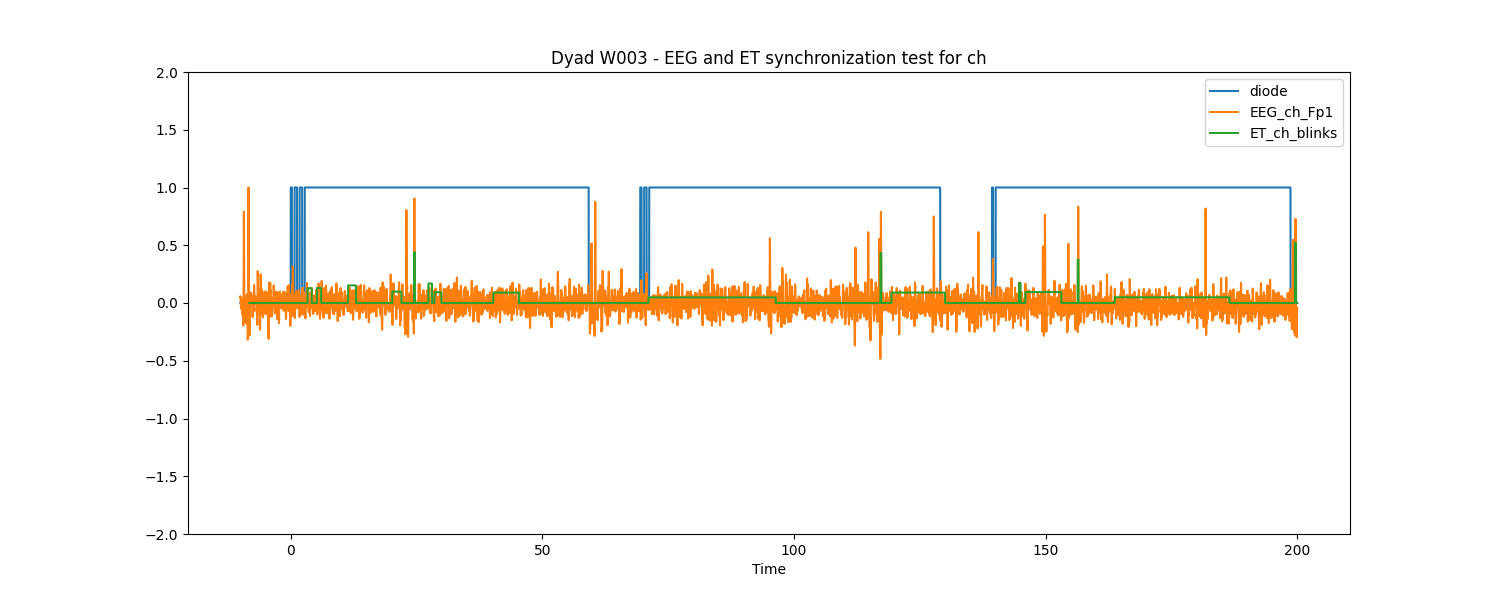

In [31]:
delta = 0.0  # to align ET with EEG (seconds): after correction applied in load_et_data the delta here should be 0 
who = 'ch' # choose 'cg' or 'ch' for caregiver or child data
data_selected = multimodal_data.data[(multimodal_data.data.time>-10)&(multimodal_data.data.time<200)]

plt.figure(figsize=(15, 6))
plt.plot(data_selected['time'], data_selected['diode'], linestyle='-', label='diode')
plt.plot(data_selected['time'], (data_selected[f'EEG_{who}_Fp1'])/np.max(data_selected[f'EEG_{who}_Fp1']), linestyle='-', label=f'EEG_{who}_Fp1')
plt.plot(data_selected['time']-delta, data_selected[f'ET_{who}_blinks'], linestyle='-', label=f'ET_{who}_blinks')
plt.legend()
plt.title(f'Dyad {dyad_id} - EEG and ET synchronization test for {who}')
plt.xlabel('Time')
plt.ylim(-2, 2)
plt.show()

## Test the aligment of the EEG and ET events

Event mapping: {None: 0, 'm3': 1, 'm2': 2, 'm1': 3, 'talk1': 4}
Event mapping for events: {None: 0, 'Incredibles': 1, 'Peppa': 2, 'Brave': 3}


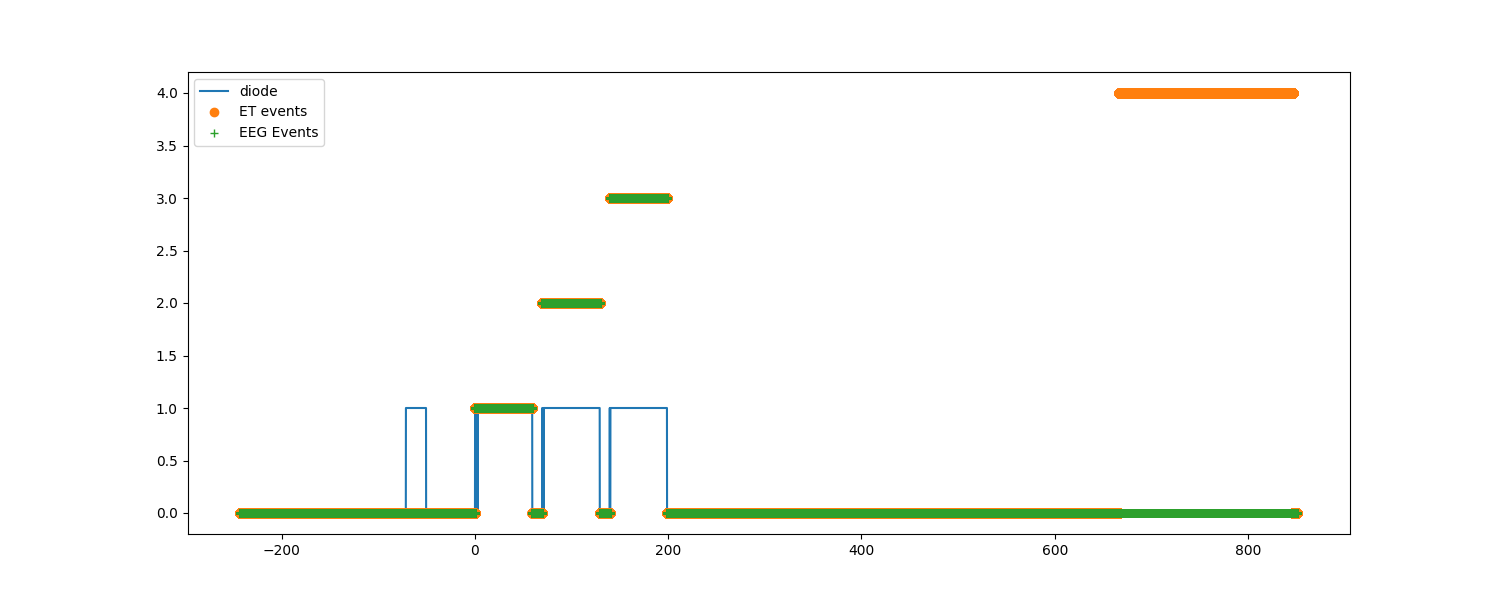

In [32]:
event_mapping = {event: idx for idx, event in enumerate(multimodal_data.data['ET_event'].unique())}
print("Event mapping:", event_mapping)

# Map ET_event to integer values
multimodal_data.data['event_num_ET'] = multimodal_data.data['ET_event'].map(event_mapping)

# create a mapping from unique events values to integers
event_mapping_events = {event: idx for idx, event in enumerate(multimodal_data.data['events'].unique())}
print("Event mapping for events:", event_mapping_events)

multimodal_data.data['event_num_events'] = multimodal_data.data['events'].map(event_mapping_events)

plt.figure(figsize=(15, 6))
plt.plot(multimodal_data.data['time'], multimodal_data.data['diode'], label='diode')
plt.plot(multimodal_data.data['time'], multimodal_data.data['event_num_ET'],'o', label='ET events')
plt.plot(multimodal_data.data['time'], multimodal_data.data['event_num_events'],'+', label='EEG Events')

plt.legend()
#plt.xlim(-10,200)
plt.show()

## Test if blinks are aligned with x-coordinate  and pupli diameter?

/var/folders/1t/qbjskh415rz70kx6_0rww8680000gp/T/ipykernel_69543/797169087.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 6))


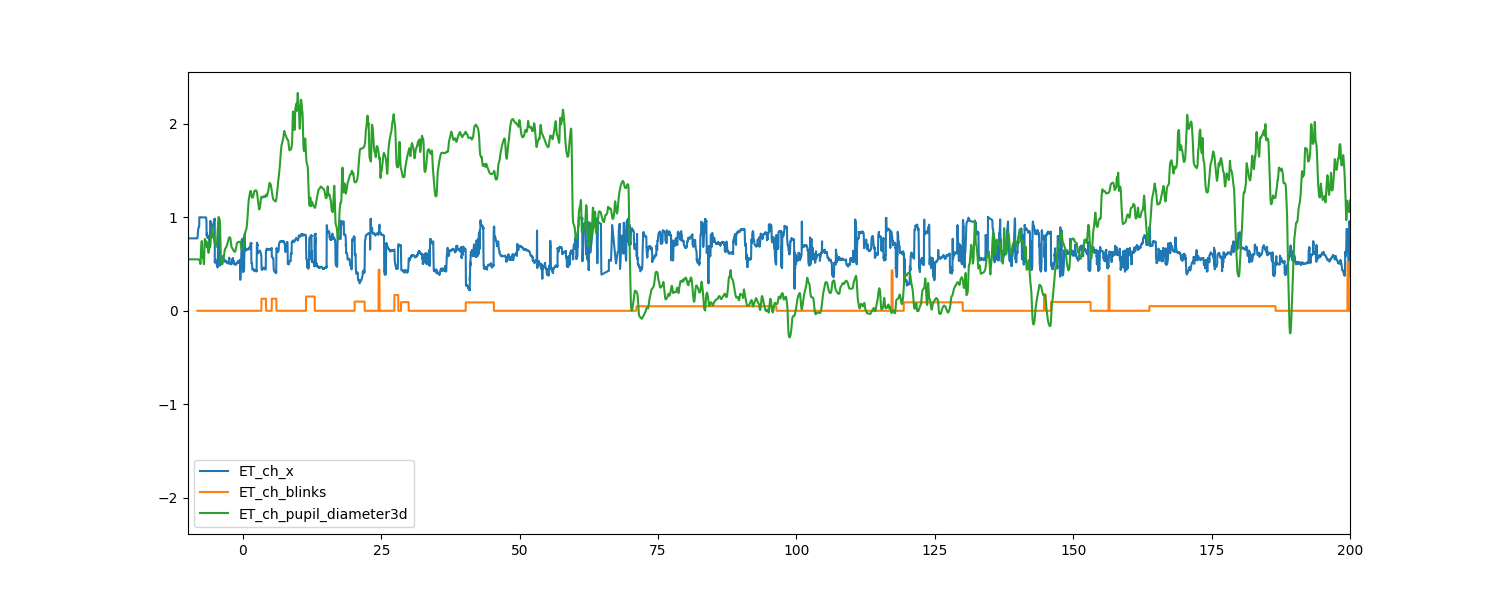

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(multimodal_data.data['time'], multimodal_data.data[f'ET_{who}_x'], label=f'ET_{who}_x')
plt.plot(multimodal_data.data['time'], multimodal_data.data[f'ET_{who}_blinks'], label=f'ET_{who}_blinks')
plt.plot(multimodal_data.data['time'], multimodal_data.data[f'ET_{who}_diameter3d']-np.mean(multimodal_data.data[f'ET_{who}_diameter3d']), label=f'ET_{who}_pupil_diameter3d')
plt.legend()
plt.xlim(-10,200)
plt.show()

In [34]:
multimodal_data.data.columns

Index(['time_idx', 'EEG_ch_Fp1', 'EEG_ch_Fp2', 'EEG_ch_F7', 'EEG_ch_F3',
       'EEG_ch_Fz', 'EEG_ch_F4', 'EEG_ch_F8', 'EEG_ch_M1', 'EEG_ch_T3',
       'EEG_ch_C3', 'EEG_ch_Cz', 'EEG_ch_C4', 'EEG_ch_T4', 'EEG_ch_M2',
       'EEG_ch_T5', 'EEG_ch_P3', 'EEG_ch_Pz', 'EEG_ch_P4', 'EEG_ch_T6',
       'EEG_ch_O1', 'EEG_ch_O2', 'EEG_cg_Fp1', 'EEG_cg_Fp2', 'EEG_cg_F7',
       'EEG_cg_F3', 'EEG_cg_Fz', 'EEG_cg_F4', 'EEG_cg_F8', 'EEG_cg_M1',
       'EEG_cg_T3', 'EEG_cg_C3', 'EEG_cg_Cz', 'EEG_cg_C4', 'EEG_cg_T4',
       'EEG_cg_M2', 'EEG_cg_T5', 'EEG_cg_P3', 'EEG_cg_Pz', 'EEG_cg_P4',
       'EEG_cg_T6', 'EEG_cg_O1', 'EEG_cg_O2', 'events', 'diode', 'ECG_ch',
       'ECG_cg', 'IBI_ch', 'IBI_cg', 'ET_event', 'ET_ch_x', 'ET_ch_y',
       'ET_ch_diameter3d', 'ET_ch_blinks', 'ET_cg_x', 'ET_cg_y',
       'ET_cg_diameter3d', 'ET_cg_blinks', 'time', 'event_num_ET',
       'event_num_events'],
      dtype='object')

## Check the relation of IBI and pupil diameter

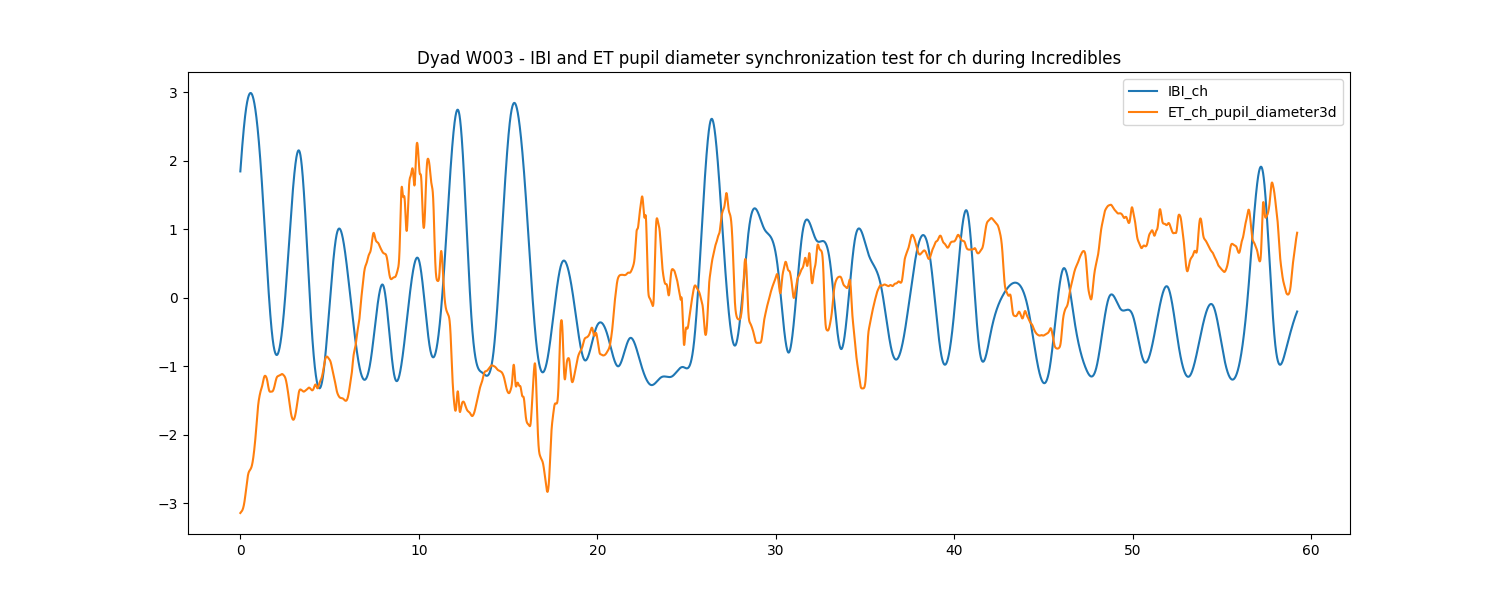

In [43]:
from scipy import stats
movie = 'Incredibles'
data_selected = multimodal_data.data[(multimodal_data.data.events == movie)]
plt.figure(figsize=(15, 6))
plt.plot(data_selected['time'], (data_selected[f'IBI_{who}'] - data_selected[f'IBI_{who}'].mean()) / data_selected[f'IBI_{who}'].std(), label=f'IBI_{who}')
plt.plot(data_selected['time'], (data_selected[f'ET_{who}_diameter3d'] - data_selected[f'ET_{who}_diameter3d'].mean()) / data_selected[f'ET_{who}_diameter3d'].std(), label=f'ET_{who}_pupil_diameter3d')
plt.legend()
plt.title(f'Dyad {dyad_id} - IBI and ET pupil diameter synchronization test for {who} during {movie}')
plt.show()